In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2024-08-11 02:12:18.829311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_path='Downloads/visuallyimpair/visual_dataset'

In [3]:
df = pd.read_csv("Downloads/visuallyimpair/visual_text/visual.token.txt")

df.columns.values[0] ="Images"
df=df.Images.str.split("#",expand=True)
# df.drop(columns=[2,3],inplace=True)
df.columns=['Images','Captions']
df['Captions']=df['Captions'].str.replace('[0-9]\t', '')
df.head()

,Images,Captions
0,greensig1.jpg,Green signal please walk .
1,greensig1.jpg,Green signal please walk .
2,greensig1.jpg,Green signal please walk .
3,greensig1.jpg,Green signal please walk .
4,greensig2.jpg,Green signal please walk .


In [4]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"Downloads/visuallyimpair/visual_dataset/{temp_df.Images[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.Captions[i], 20)))
        plt.axis("off")

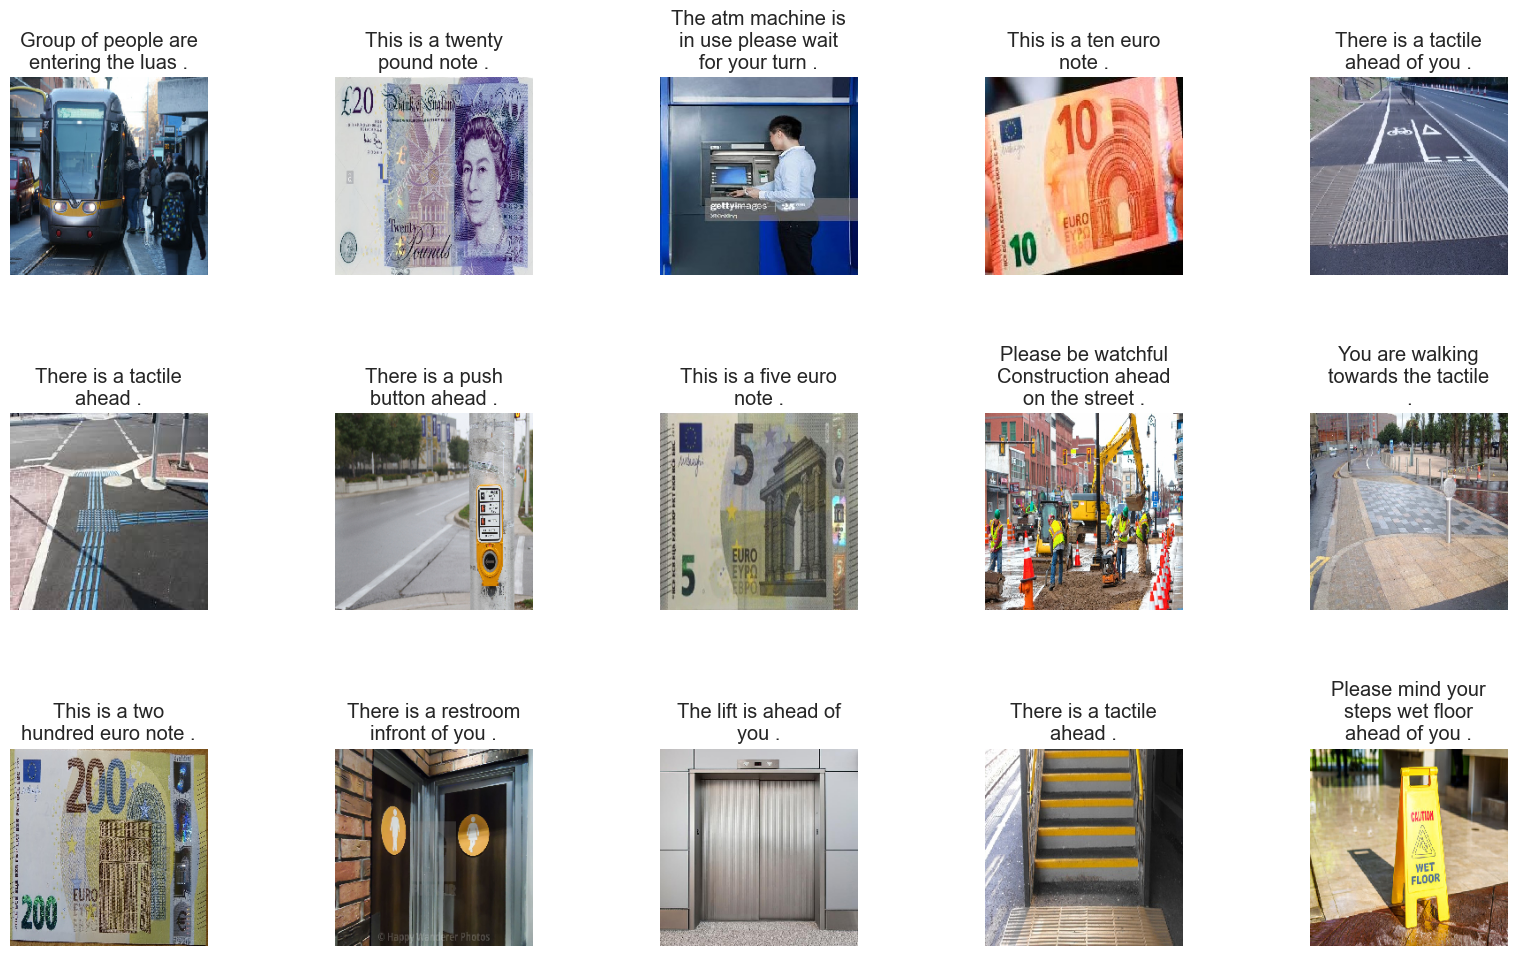

In [5]:
display_images(df.sample(15))

In [6]:
def preprocess_text(df):
    df['Captions'] = df['Captions'].str.lower()
#     df['Captions'] = df['Captions'].str.replace('[^A-Za-z]', '')
#     df['Captions'] = df['Captions'].str.replace('\s+', ' ')
    df['Captions'] = "startseq "+df['Captions']+" endseq"
    return df

In [7]:
df=preprocess_text(df)

In [8]:
df

,Images,Captions
0,greensig1.jpg,startseq green signal please walk . endseq
1,greensig1.jpg,startseq green signal please walk . endseq
2,greensig1.jpg,startseq green signal please walk . endseq
3,greensig1.jpg,startseq green signal please walk . endseq
4,greensig2.jpg,startseq green signal please walk . endseq
...,...,...
7994,playing50.jpg,startseq kids are playing in the park . endseq
7995,playing50.jpg,startseq kids are sitting in the park . endseq
7996,playing50.jpg,startseq kids are sitting in the garden . endseq
7997,playing50.jpg,startseq group of kids sitting in the park . e...


In [9]:
captions = []
for caption in df['Captions']:
        captions.append(caption)

In [10]:
captions[:10]

['startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq',
 'startseq green signal please walk . endseq']

In [11]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in captions)

images = df['Images'].unique().tolist()
images_no = len(images)

split_index = round(0.80*images_no)
train_images = images[:split_index]
val_images = images[split_index:]

train =df[df['Images'].isin(train_images)]
test = df[df['Images'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

print("Vocab Size is :",vocab_size)
print("Max Lenght is :",max_length)


Vocab Size is : 150
Max Lenght is : 18


# feature Extraction

In [12]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 118s 0us/step


In [13]:
img_size = 224
features = {}
for image in tqdm(df['Images'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = model.predict(img, verbose=0)
    features[image] = feature

  0%|          | 0/1600 [00:00<?, ?it/s]

In [14]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [15]:
input1 = Input(shape=(4096,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [16]:
train_generator = CustomDataGenerator(df=train,X_col='Images',y_col='Captions',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='Images',y_col='Captions',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [19]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)


In [22]:
history = caption_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator)
#         callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - loss: 4.2383 - val_loss: 4.4467
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 636ms/step - loss: 2.5820 - val_loss: 4.4743
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 638ms/step - loss: 1.3518 - val_loss: 5.3856
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 635ms/step - loss: 0.8912 - val_loss: 5.9295
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 64s 641ms/step - loss: 0.6910 - val_loss: 6.2870


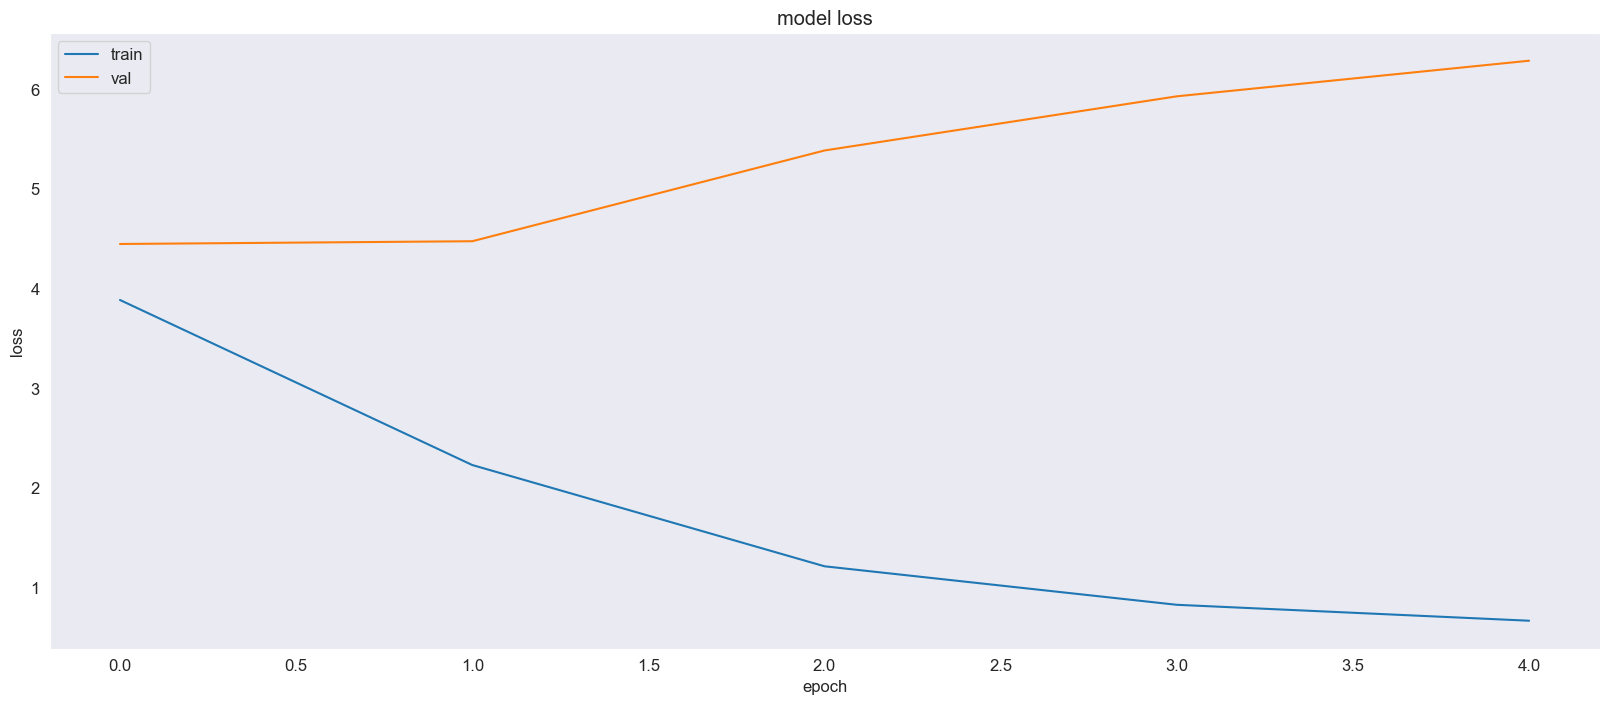

In [23]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [25]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [26]:
samples = train.sample(15)
samples.reset_index(drop=True,inplace=True)

In [27]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['Images']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['Images'], tokenizer, max_length, features)
    samples.loc[index,'Captions'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

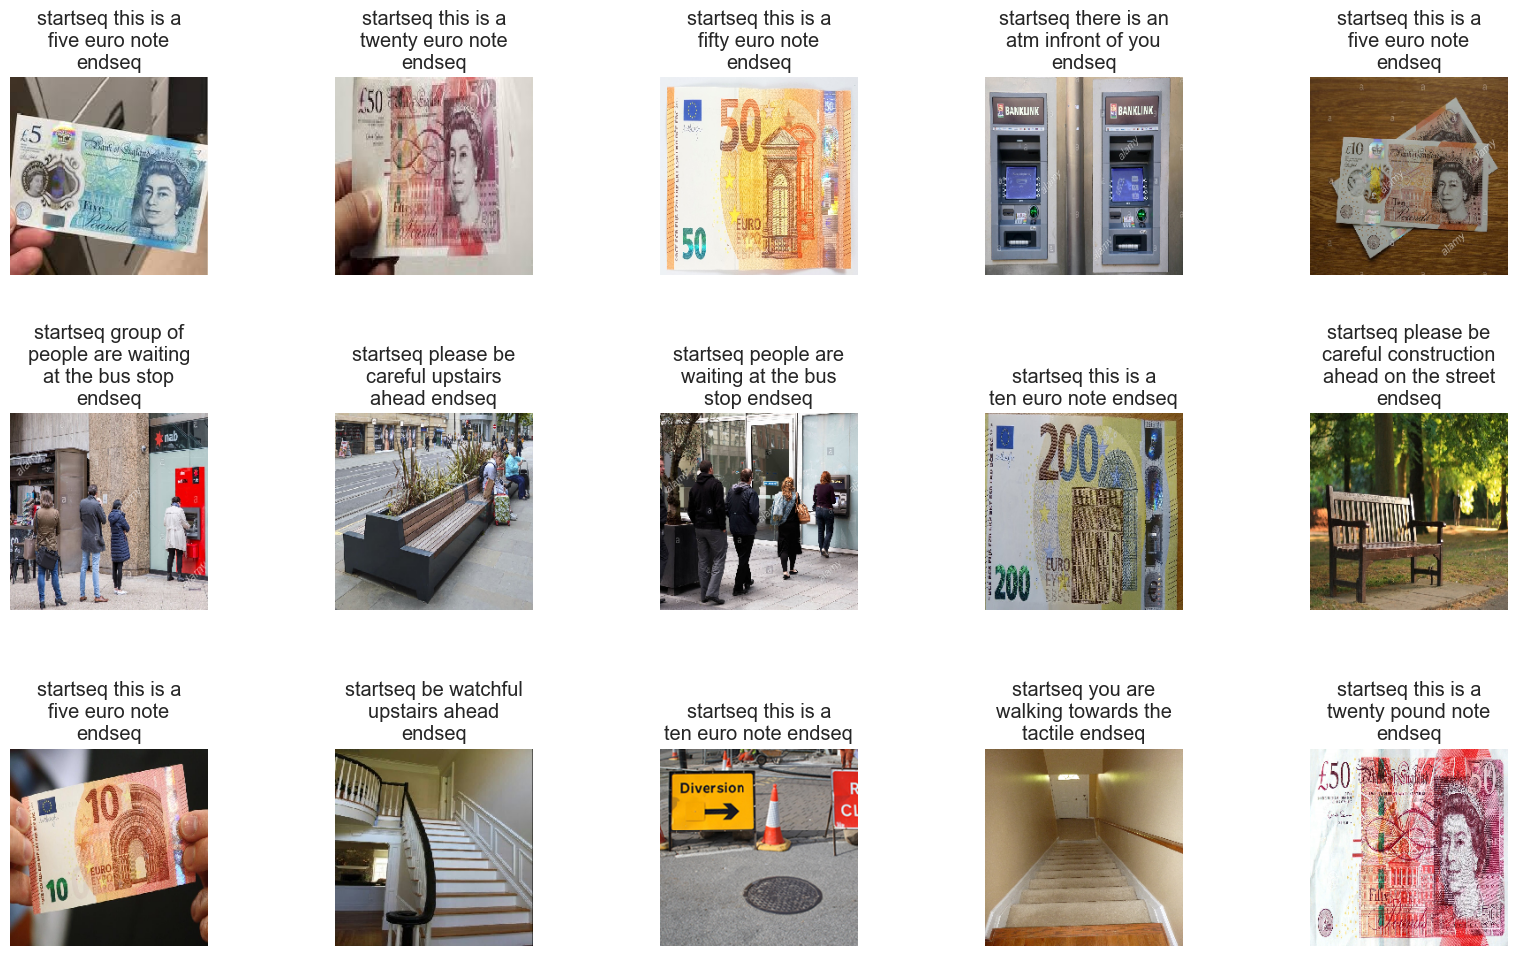

In [28]:
display_images(samples)

In [29]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = df['Captions']
    # predict the caption for image
    y_pred = predict_caption(caption_model, record['Images'], tokenizer, max_length, features)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1600 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
BLEU-1: 1.000000
BLEU-2: 0.925820
